![spicy_meme](https://github.com/crowegian/memes/blob/master/overfittingMemesAreMyLife.jpg?raw=true)


# Notes For TA:
This lab might be too hard. It's easier if you know how to work around creating python classes with what you need, but even then trainig can go wrong so you need to be able to experiment with different loss functions (BCE vs BCEWithLogits).

# Implementing Binary Classification Models
Today you'll learn to implement 3 binary classifcation models starting with logistic regression. Logistic regression is a standard model, and as you'll see it's simple to change certain parts of its implementation to end up with completely different models. We won't go into it today, but these small changes can make models perform very differently under the same conditions.

### First start out by installing SciKit-learn
Install Scikit-learn into your computational methods environment with `conda install scikit-learn`
Scikit-learn is a great library to be comfortable with, as it allows you to perform a lot of the routine data science steps quickly.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Part 1: Let's get this data, fam
Load in the breast cancer dataset from Scikit-learn, and perform a random train, validation split on the data. You'll want four variables `X_train`, `X_val`, `Y_train` and `Y_val`.

Tips:
1. Scitkit-learn has a lot of functionality for machine learning projects. Look into how you might get a random training and validation split from your data
2. When you're building your own models a lot of things can go wrong. Like, a lot. And it happens to the best of us. One way you can troubleshoot your models is to use a trivial subset of the entire training data, say ~10 examples, and make sure your model can perfectly learn these examples. I would suggest adding in a switch to allow you to perform testing runs where you reduce your dataset to ~10 examples.

In [2]:
#### your code here ####
TESTING = False
data = load_breast_cancer()
n = data.data.shape[0]
valFrac = 0.3
X = data.data
Y = data.target.reshape([X.shape[0], 1])
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = valFrac, random_state = 1876)
if TESTING:
    X_train = X_train[0:10,:]
    X_val = X_train
    Y_train = Y_train[0:10]
    Y_val = Y_train
X_train = torch.from_numpy(X_train).float()
X_val = torch.from_numpy(X_val).float()
Y_train = torch.from_numpy(Y_train).float()
Y_val = torch.from_numpy(Y_val).float()
print("n Train: {}\nn Val: {}".format(X_train.shape[0], X_val.shape[0]))

n Train: 398
n Val: 171


# Part 2: Classification Functions

## Logistic Regression
Logistic regression is your bread and butter baseline classification model. Before implementing anything too fancy, you should see how far logistic regression can get you. When should you use logistic regression? Whenever you're performing supervised learning and have a binary response variable (only two classes). Luckily for us, most of the math for a logistic regression model has already been worked out in Lab 3 with linear regression. But there's just one problem, linear regression is unbounded, and if we're doing classification we want our model to predict the probability of a model belonging to one class or the other. So instead of letting our model's outputs be between $-\infty$ and $\infty$ we want to constrain it between $0$ and $1$.

To blatantly plagiarize another TAs work, in least squares linear regression we have a feature matrix $X$ and a set of corresponding outcomes $Y$, and the goal is to learn a $\beta$ such that $\hat{Y} = X^\top \beta + \epsilon$ minimizes the loss function $\sum_i (Y - \hat{Y})^2$, with $\mathbb{E}[\epsilon] = 0$.

Using the input $X$ and our model parameters $\beta$ we'll convert linear regression into logistic regression. First, why do we want to bound our model between $0$ and $1$? Because we're doing classification we need an easy way to define when our prediction is for one class or the other, and if our model can only output probabilities then we can use a cutoff (say $0.5$) and bin every observation into a class. Squashing inputs between $0$ and $1$ is done using the sigmoid function $\sigma(a) = \frac{1}{1 + exp(-a)}$. Using our inputs $X$, our learned parameters $\beta$ and $\sigma(\cdot)$ we have the makings of greatness, or at least some kind of baseline model. We write the probability of our 'positive' class (an arbiterary designation) as $$p(Y = 1|X;\beta) = \sigma(\beta^{T}X)$$ and our 'negative' class as $$p(Y = 0|X;\beta) = 1 - \sigma(\beta^{T}X)$$ For simplicity's sake let $a = \beta^{T}X$ or $a_i = \beta^{T}x_i$ for a specific observation for he remainder of this cell

The loss function for logistic regression is similar to what we used in Lab 2 for MLE. For a single observation $x_i$ and its response variable $y_i$ we define our prediction's loss as $L(\beta;y_i, x_i) = \sigma(a_i)^{y_i}(1 - \sigma(a_i))^{1-y_i}$. And for an entire dataset of $n$ examples after taking the log our loss is

$$\frac{-1}{n}\sum_{i=1}^n y_ilog(\sigma(a_i)) + (1-y_i)log(1-\sigma(a_i))$$

Using our usual tools of gradient descent, and stochastic gradient descent we can now learn the parameters $\beta$ which minimize our loss


In [3]:
class binaryClassifier(nn.Module):
    """
        A general classifier that can use multiple activation functions, or none at all.
        By making the activation function we use an argument during initialization we don't
        have to make a different function every time we want to change up the activation
        function. We want to also have the option of having no activation function, so the 
        model behaves just like a linear regression without an activation function.
    """
    # The class constructor defines the parameters (ie layers) of the neural network
    # add an init function which allows us to pass in arbitrary activation functions
    # and defaults to None.
    
    
    #### your code here ####
    def __init__(self, nFeats, activationFunction = None):
    #### end your code ####
    
    
        super(binaryClassifier, self).__init__()
        # What type of parameters do we need to add?
        
        
        self.linear = nn.Linear(in_features = nFeats, out_features = 1)
        # Do not remove the line below. It allows the model to learn by initializing small weights
        self.linear.weight= torch.nn.init.xavier_uniform_(self.linear.weight, gain = 0.001)
        
        
        # Store the activation function in our object
        #### your code here ####
        self.activationFunction = activationFunction
        #### end your code ####
        
        
        
    def forward(self, x):
        # Write a forward pass function which optionally uses the activation function
        #### your code here ####
        if self.activationFunction is None:
            out = self.linear(x)
        else:
            out = self.activationFunction(self.linear(x))
        return(out)
        #### end your code ####

In [4]:
# Initialize a binaryClassifier object, with the appropriate loss function from torch.nn.
# Tip: Pytorch defines multiple loss functions. Look them up and see which one is in line
    # with the loss function we defined for a logistic regression model
#### your code here ####
logisticRegressionModel = binaryClassifier(nFeats = X_train.shape[1], activationFunction = None)
lossFunction = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(logisticRegressionModel.parameters(), lr = .00001, momentum = 0.9)
#### end your code ####

### Learning our logistic model
Now we're ready to learn our model. Using the skeleton code below fill in what you'll need to perform a forward pass, calculate the loss, and update the parameters at each epoch. **Keep track of and plot your training and validation loss at each step** after the model converges

In [5]:
epochs = 100
logisticLossVal = []
logisticLossTrain = []
for epoch in range(epochs):
    #### your code here ####   
    # Estimate Y_hat with the current model
    Y_hat = logisticRegressionModel(X_train)
    
    # Compute the training
    loss = lossFunction(Y_hat, Y_train)
    logisticLossTrain.append(loss.data.numpy())
    # compute the validation loss and store it.
    valLoss = lossFunction(logisticRegressionModel(X_val), Y_val)
    logisticLossVal.append(valLoss.data.numpy())
    # Compute the gradient of the loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print("loss {0:.3f}, val loss {1:.3f}".format(logisticLossTrain[-1],
                                           logisticLossVal[-1]))
#### end your code ####

loss 0.693, val loss 0.688
loss 0.538, val loss 0.510
loss 0.418, val loss 0.387
loss 0.359, val loss 0.336
loss 0.324, val loss 0.307
loss 0.301, val loss 0.289
loss 0.285, val loss 0.276
loss 0.273, val loss 0.267
loss 0.265, val loss 0.259
loss 0.258, val loss 0.254


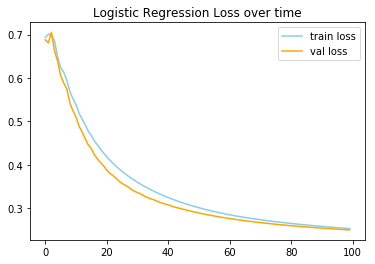

In [6]:
plt.plot(logisticLossTrain, color = "skyblue", label = "train loss")
plt.plot(logisticLossVal, color = 'orange', label = "val loss")
plt.legend()
plt.title("Logistic Regression Loss over time")
plt.show()

## Probit Model

We defined $p(Y = 1|a) = \sigma(a)$ in logistic regression, but the more general form of a linear model would be $p(Y = 1|X;\beta) = f(\beta^{T}X)$ where $f(\cdot)$ is known as an activation function. Another activation function we could have used is known as the inverse probit function which is the cumulative distribution function of a standard normal defined as $\Phi(a) = \frac{1}{2}(1 + erf(\frac{1}{\sqrt{2}}))$ (Did you hear that? That was the sound of an absolute ton of details being skipped over. For more information about probit regression go [here](https://en.wikipedia.org/wiki/Probit_model)). Here $erf(\cdot)$ is known as the error function. All the same steps apply for the logistic regression example, except instead of $\sigma(\cdot)$ we use $\Phi(\cdot)$

$$\frac{-1}{n}\sum_{i=1}^n y_ilog(\Phi(a_i)) + (1-y_i)log(1-\Phi(a_i))$$



Tips:
1. For the love of your weekend don't try to implement the CDF of a normal distribution. Search around and find out how you can get the cdf of different distributions in using Pytorch.

In [7]:
# Initialize a binaryClassifier object, with the appropriate loss function from torch.nn, and the
# activation function discussed above.
# Tip: If you notice the model is not learning, or the loss is going up, try tuning the learning rate
#### your code here ####
normDist = torch.distributions.normal.Normal(0, 1)
probitRegressionModel = binaryClassifier(nFeats = X_train.shape[1], activationFunction = normDist.cdf)
lossFunction = nn.BCELoss()
optimizer = torch.optim.SGD(probitRegressionModel.parameters(), lr = .000001, momentum = 0.9)
#### end your code ####

### Learning our probit model
Now we're ready to learn our model. Using the skeleton code below fill in what you'll need to perform a forward pass, calculate the loss, and update the parameters at each epoch. **Keep track of and plot your training and validation loss at each step** after the model converges

In [8]:
epochs = 100
probitLossTrain = []
probitLossVal = []
for epoch in range(epochs):
    #### your code here ####
    # Estimate Y_hat with the current model
    
    Y_hat = probitRegressionModel(X_train)
    
    # Compute the loss
    loss = lossFunction(Y_hat, Y_train)
    probitLossTrain.append(loss.data.numpy())
    # compute the validation loss and store it.
    valLoss = lossFunction(probitRegressionModel(X_val), Y_val)
    probitLossVal.append(valLoss.data.numpy())
    
    # Compute the gradient of the loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print("loss {0:.3f}, val loss {1:.3f}".format(probitLossTrain[-1],
                                           probitLossVal[-1]))
    #### end your code ####

loss 0.673, val loss 0.664
loss 0.621, val loss 0.602
loss 0.553, val loss 0.526
loss 0.501, val loss 0.472
loss 0.464, val loss 0.434
loss 0.436, val loss 0.408
loss 0.415, val loss 0.387
loss 0.397, val loss 0.371
loss 0.381, val loss 0.358
loss 0.368, val loss 0.346


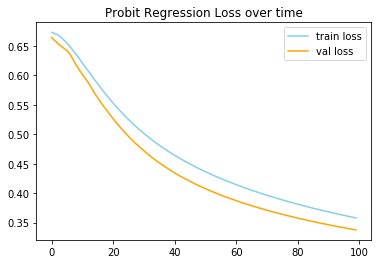

In [9]:
plt.plot(probitLossTrain, color = "skyblue", label = "train loss")
plt.plot(probitLossVal, color = 'orange', label = "val loss")
plt.legend()
plt.title("Probit Regression Loss over time")
plt.show()

## Hinge Loss
We can also change the loss function we use in logistic regression to the hinge loss by reconfiguring how we view the data. To do this we formulate our response variable as either $-1$ or $1$. The hinge loss is $l(y_i, a) = max(0, 1 - y_i*a_i))$ where $a_i = \beta^Tx_i$. The intuition behind this is that we don't care exactly what our model predicts, we just want the sign to be right. If our $a$ has the same sign as $y$ and $|a|\geq1$ no loss is incurred, but if $a$ and $y$ have opposite signs or $|a| < 1$ a linearly increasing.

The loss above is for a single observation, but as with the other loss functions we take the average over many examples. **Implement the hinge loss below and use it to train a new model**

Note: The hinge loss is used a class of models known as [support vector machines](https://en.wikipedia.org/wiki/Support-vector_machine), which attempt to cleanly separate data onto either side of a hyperplane, and maximizes the distance between the closest points on either side or margin. 

In [10]:
def myHingeLoss(a, y):
    #### your code here ####
    out = torch.max(y*0, 1 - y*a)
    out = torch.mean(out)
    return(out)
    #### end your code ####

In [11]:
# Initialize a binaryClassifier object, with the loss function defined above.
#### your code here ####
hingeLossModel = binaryClassifier(nFeats = X_train.shape[1], activationFunction = None)
lossFunction = myHingeLoss
optimizer = torch.optim.SGD(hingeLossModel.parameters(), lr = .00001, momentum = 0.9)
#### end your code ####

In [12]:
# The hinge loss model requires our data is -1 or 1.
Y_train_hinge = Y_train.clone().detach()# I'm performing a deep copy of the model here. Otherwise
# I'd just get a pointer to the original and weird things would happen.
Y_train_hinge[Y_train_hinge == 0] = -1
Y_val_hinge = Y_val.clone().detach()
Y_val_hinge[Y_val_hinge == 0] = -1

### Learning our hinge loss model
Now we're ready to learn our model. Using the skeleton code below fill in what you'll need to perform a forward pass, calculate the loss, and update the parameters at each epoch. **Keep track of and plot your training and validation loss at each step** after the model converges

In [13]:
epochs = 100
logisticHingeLossTrain = []
logisticHingeLossVal = []
for epoch in range(epochs):
    #### your code here ####
    # Estimate Y_hat with the current model
    
    Y_hat = hingeLossModel(X_train)
    
    # Compute the loss
    loss = lossFunction(Y_hat,Y_train_hinge)
    logisticHingeLossTrain.append(loss.data.numpy())
    # compute the validation loss and store it.
    valLoss = lossFunction(hingeLossModel(X_val), Y_val_hinge)
#     if epoch % 100 == 0:
#         print(valLoss)
    logisticHingeLossVal.append(valLoss.data.numpy())        
    # Compute the gradient of the loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print("loss {0:.3f}, val loss {1:.3f}".format(logisticHingeLossTrain[-1],
                                           logisticHingeLossVal[-1]))
    #### end your code ####

loss 1.064, val loss 1.084
loss 2.367, val loss 2.685
loss 0.738, val loss 0.669
loss 0.357, val loss 0.328
loss 0.302, val loss 0.273
loss 0.250, val loss 0.232
loss 0.229, val loss 0.223
loss 0.216, val loss 0.212
loss 0.209, val loss 0.206
loss 0.207, val loss 0.202


In [12]:
x = None
None

In [11]:
x is None

False

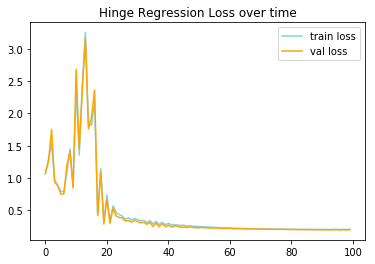

In [14]:
plt.plot(logisticHingeLossTrain, color = "skyblue", label = "train loss")
plt.plot(logisticHingeLossVal, color = 'orange', label = "val loss")
plt.legend()
plt.title("Hinge Regression Loss over time")
plt.show()

# Part 3: Overfitting
In class we talked about a overfitting a model, where the model learns the training data so well that it no longer generalizes to the validation or test set. **In this section train a model that overfits the training data to the point where validation performance suffers. Describe what you did and plot the validation and training loss across epochs** Depending on how your split your data you may have already seen overfitting. In that case just make your model overfit even more.

In [15]:
## Increasing the number of epochs should get the trick done. Could also add in extra parameters but that
# sounds like work
logisticRegressionModel = binaryClassifier(nFeats = X_train.shape[1], activationFunction = None)
lossFunction = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(logisticRegressionModel.parameters(), lr = .00001, momentum = 0.9)
epochs = 20000
logisticLossVal = []
logisticLossTrain = []
for epoch in range(epochs):
    #### your code here ####   
    # Estimate Y_hat with the current model
    Y_hat = logisticRegressionModel(X_train)
    
    # Compute the training
    loss = lossFunction(Y_hat, Y_train)
    logisticLossTrain.append(loss.data.numpy())
    # compute the validation loss and store it.
    valLoss = lossFunction(logisticRegressionModel(X_val), Y_val)
    logisticLossVal.append(valLoss.data.numpy())
    # Compute the gradient of the loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print("loss {0:.3f}, val loss {1:.3f}".format(logisticLossTrain[-1],
                                           logisticLossVal[-1]))
#### end your code ####

loss 0.723, val loss 0.745
loss 0.198, val loss 0.206
loss 0.190, val loss 0.198
loss 0.185, val loss 0.193
loss 0.181, val loss 0.190
loss 0.179, val loss 0.188
loss 0.176, val loss 0.187
loss 0.175, val loss 0.186
loss 0.173, val loss 0.185
loss 0.172, val loss 0.184
loss 0.171, val loss 0.183
loss 0.170, val loss 0.183
loss 0.169, val loss 0.182
loss 0.168, val loss 0.181
loss 0.167, val loss 0.180
loss 0.167, val loss 0.180
loss 0.166, val loss 0.179
loss 0.165, val loss 0.178
loss 0.164, val loss 0.178
loss 0.164, val loss 0.177


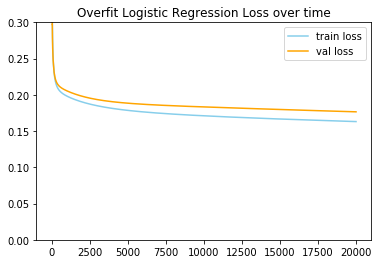

In [16]:
plt.plot(logisticLossTrain, color = "skyblue", label = "train loss")
plt.plot(logisticLossVal, color = 'orange', label = "val loss")
plt.legend()
plt.title("Overfit Logistic Regression Loss over time")
plt.ylim([0, 0.3])
plt.show()